In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch.fft
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

torch.Size([512, 512])


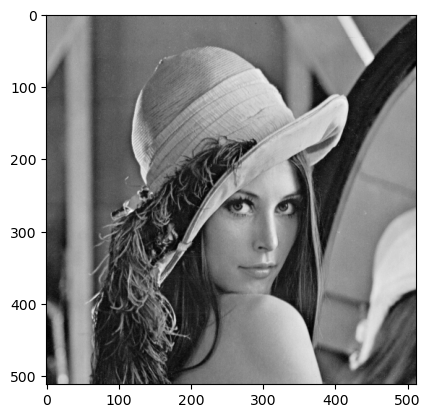

In [21]:
img = Image.open('lena_gray.jpg')
img = img.convert('L')
img = np.array(img)
img = torch.from_numpy(img)
print(img.shape) # (512, 512)
plt.imshow(img)

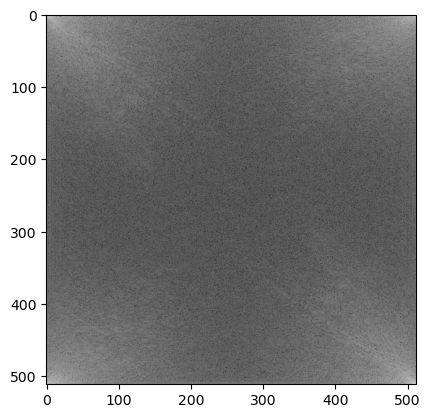

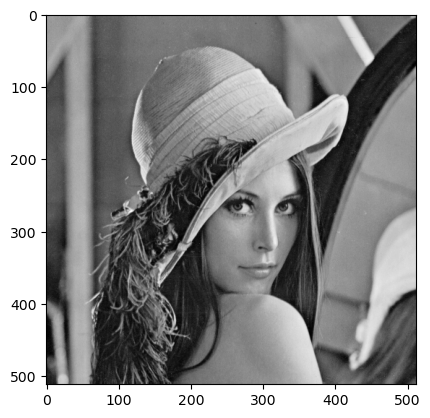

In [25]:
# fft_img = torch.fft.fftshift(img)
# fft_img = torch.fft.fftshift(img)
ft_img = torch.fft.fft2(img)
# ft_img = torch.fft.fftshift(ft_img)
# print(fft_img.shape)  # torch.Size([512, 512])
plt.set_cmap("gray")
plt.imshow(np.log(np.abs(ft_img.view(512, 512))))
plt.show()

# now ifft
# ift = torch.fft.ifftshift(ft_img)
ift = torch.fft.ifft2(ft_img)
# ift = torch.fft.fftshift(ift)
plt.imshow(ift.real.view(512, 512).detach().numpy())

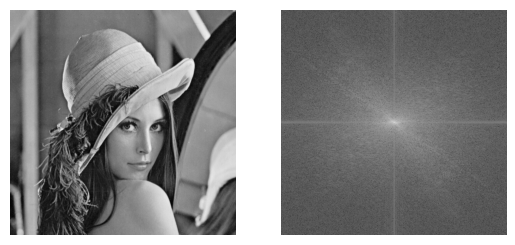

In [4]:
# print(fft_img[0][:5])

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)

def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

# Read and process image
plt.set_cmap("gray")
ft = calculate_2dft(img)
plt.subplot(121)
plt.imshow(img)
plt.axis("off")
plt.subplot(122)
plt.imshow(np.log(abs(ft)))
plt.axis("off")
plt.show()

In [5]:
def roll_n(X, axis, n):
    f_idx = tuple(slice(None, None, None) 
            if i != axis else slice(0, n, None) 
            for i in range(X.dim()))
    b_idx = tuple(slice(None, None, None) 
            if i != axis else slice(n, None, None) 
            for i in range(X.dim()))
    front = X[f_idx]
    back = X[b_idx]
    return torch.cat([back, front], axis)
def fftshift(X):
    real, imag = X.chunk(chunks=2, dim=-1)
    real, imag = real.squeeze(dim=-1), imag.squeeze(dim=-1)
    for dim in range(2, len(real.size())):
        real = roll_n(real, axis=dim, 
                      n=int(np.ceil(real.size(dim) / 2)))
        imag = roll_n(imag, axis=dim, 
                      n=int(np.ceil(imag.size(dim) / 2)))
    real, imag = real.unsqueeze(dim=-1), imag.unsqueeze(dim=-1)
    X = torch.cat((real,imag),dim=1)
    return torch.squeeze(X)
def ifftshift(X):
    real, imag = X.chunk(chunks=2, dim=-1)
    real, imag = real.squeeze(dim=-1), imag.squeeze(dim=-1)
    
    for dim in range(len(real.size()) - 1, 1, -1):
        real = roll_n(real, axis=dim, 
                      n=int(np.floor(real.size(dim) / 2)))
        imag = roll_n(imag, axis=dim, 
                      n=int(np.floor(imag.size(dim) / 2)))
    real, imag = real.unsqueeze(dim=-1), imag.unsqueeze(dim=-1)
    X = torch.cat((real, imag), dim=1)
    return torch.squeeze(X)

### Apply the high pass filter

In [18]:
fft_shift_img = fftshift(fft_img)
filter_rate   = 0.85
h, w          = fft_shift_img.shape[:2] # height and width
cy, cx        = int(h/2), int(w/2) # centerness
rh, rw        = int(filter_rate * cy), int(filter_rate * cx) # filter_size

# the value of center pixel is zero.
fft_shift_img[cy-rh:cy+rh, cx-rw:cx+rw] = 0

In [19]:
# restore the frequency image
ifft_shift_img = ifftshift(fft_shift_img)

# inverce fft
ifft_img = torch.fft.ifft(ifft_shift_img)

C:\Users\johnk\AppData\Local\Temp\ipykernel_12784\169431181.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ifft_img = ifft_img.real.astype(np.int)


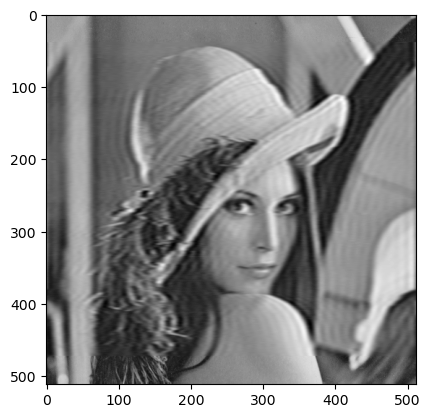

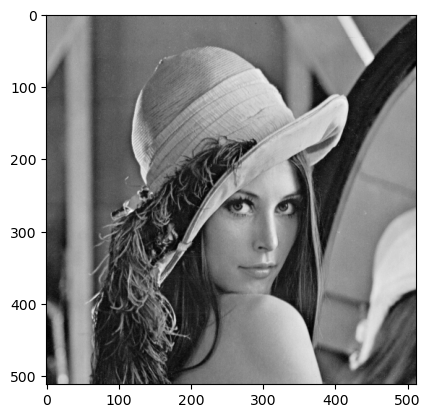

In [20]:
ifft_img = ifft_img.to('cpu').detach().numpy().copy()
ifft_img = ifft_img.real.astype(np.int)
plt.imshow(ifft_img, cmap='gray')
plt.show()

plt.imshow(img, cmap='gray')
plt.show()

Done


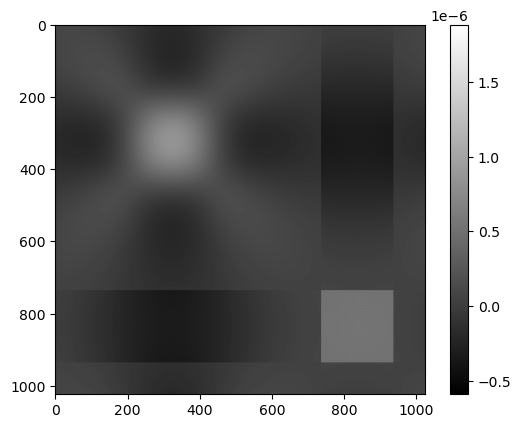

In [42]:
import os, sys
import torch
import numpy as np
import scipy as sp
import scipy.sparse as sparse
from scipy.constants import mu_0
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torch.optim as optim
from scipy.sparse.linalg import spsolve

import torchvision
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from time import time


class pytorch_mesh():

    """

        a light version of discretize that uses pytorch as base of all mechanics
        behind the scenes

    """
    
    def __init__(
        self,
        mesh_size: list=[],
        cell_size: list=[],
        padding_growth: list=[],
        number_of_padding_cells: int=5,
    ) -> None:
        """

            initiate a pytorch mesh with parameters defining the geometry.

        """

        self.dim              = torch.FloatTensor(mesh_size)
        self.h                = torch.FloatTensor(cell_size)
        self.padding          = padding_growth
        self.number_pad_cells = number_of_padding_cells



class magnetics(nn.Module):
    def __init__(self, dim, h, dirs, device='cpu'):
        super(magnetics, self).__init__()
        self.dim    = dim   # Mesh size [nx, ny, nz]
        self.h      = h     # cell size [Dx, Dy, Dz]
        self.dirs   = dirs  # magnetic field directions [A, I, A0, I0]
        self.device = device 


    def forward_old(self, M):
        # Solve the forward problem using FFT
        Dz = self.h[2]
        Z  = Dz/2
        dV = torch.prod(self.h)
        Data = 0 
        for i in range(M.shape[-1]):
            I = M[:,:,i]
            P, center, Rf = self.psfLayer(Z)
            
            S = torch.fft.fftshift(torch.roll(P, shifts=center, dims=[0,1])).unsqueeze(0).unsqueeze(0)
            B = torch.real(torch.fft.ifftshift(S * torch.fft.fftshift(I))) 
            Data = Data+B
            Z = Z + Dz
        return Data*dV

    def forward(self, M):
        # Solve the forward problem using FFT
        Dz = self.h[2]
        Z  = Dz/2
        dV = torch.prod(self.h)
        Data = 0 
        for i in range(M.shape[-1]):
            I = M[:,:,i]
            P, center, Rf = self.psfLayer(Z)
            
            S = torch.fft.fftshift(torch.roll(P, shifts=center, dims=[0,1]))
            S = torch.fft.fft2(S)
            S = torch.fft.fftshift(S)

            I_fft = torch.fft.ifftshift(I)
            I_fft = torch.fft.ifft2(I_fft)

            B = torch.fft.fftshift(S * I_fft)
            B = torch.real(torch.fft.ifft2(B))
            Data = Data+B
            Z = Z + Dz
        return Data*dV

    def adjoint(self, I):
        
        Dz = self.h[2]
        dV = torch.prod(self.h)
        Z = Dz/2
        M  = torch.zeros(self.dim[0], self.dim[1], self.dim[2], device=self.device)
        #Mw  = torch.zeros(self.dim[0], self.dim[1], self.dim[2], device=self.device)
        
        for i in range(M.shape[-1]):
            P, center, Rf = self.psfLayer(Z)

            S = torch.fft.fft2(torch.roll(P, shifts=center, dims=[0,1])).unsqueeze(0).unsqueeze(0)
            B = torch.real(torch.fft.fft2(S * torch.fft.ifft2(torch.roll(I, shifts=center, dims=[0,1])))) 
            M[:,:,i] = B

            Z = Z + Dz

        return M*dV

    def depthWeighting(self, I):
        
        Dz = self.h[2]
        dV = torch.prod(self.h)
        Z = Dz/2
        M = torch.zeros_like(I)
        
        for i in range(I.shape[-1]):
            _, center, Rf = self.psfLayer(Z)

            S = torch.fft.fft2(torch.roll(Rf, shifts=center, dims=[0,1])).unsqueeze(0).unsqueeze(0)
            B = torch.real(torch.fft.fft2(S * torch.fft.ifft2(I))) 
            M[:,:,i] = B

            Z = Z + Dz

        return M*dV


    def psfLayer(self, Z):
         #I is the magnetization dip angle 
         # A is the magnetization deflection angle
         # I0 is the geomagnetic dip angle
         # A0 is the geomagnetic deflection angle

        dim2 = torch.div(self.dim,2,rounding_mode='floor')
        Dx = self.h[0]
        Dy = self.h[1]
        I  = self.dirs[0]
        A  = self.dirs[1]
        I0 = self.dirs[2]
        A0 = self.dirs[3]
        
        x = Dx*torch.arange(-dim2[0]+1,dim2[0]+1, device=self.device)
        y = Dy*torch.arange(-dim2[1]+1,dim2[1]+1, device=self.device)
        X,Y = torch.meshgrid(x,y)

        # Get center ready for fftshift.
        center = [-int(dim2[0]), -int(dim2[1])]

        Rf = torch.sqrt(X**2 + Y**2 + Z**2)**5
        PSFx = (2*X**2 - Y**2 - Z**2)/Rf*torch.cos(I)*torch.sin(A) + \
               3*X*Y/Rf**torch.cos(I)*torch.cos(A) + \
               3*X*Z/Rf*torch.sin(I)

        PSFy = 3*X*Y/Rf*torch.cos(I)*torch.sin(A) + \
               (2*Y**2 - X**2 - Z**2)/Rf*torch.cos(I)*torch.cos(A) + \
               3*Y*Z/Rf*torch.sin(I)

        PSFz = 3*X*Z/Rf*torch.cos(I)*torch.sin(A) + \
               3*Z*Y/Rf*torch.cos(I)*torch.cos(A) +\
               (2*Z**2 - X**2 - Y**2)/Rf*torch.sin(I)

        PSF = PSFx*torch.cos(I0)*torch.cos(A0) + \
              PSFy*torch.cos(I0)*torch.sin(A0) + \
              PSFz*torch.sin(I0) 
        
        return PSF, center, Rf

# if False:
# Adjoint test
dim = torch.tensor([1024,1024,512])
h = torch.tensor([100.0, 100.0, 100.0])
dirs = torch.tensor([np.pi/4, np.pi/4, np.pi/4, np.pi/4])
forMod = magnetics(dim, h, dirs)

M = torch.ones(dim[0], dim[1], dim[2], device='cpu') * 0.001
M[600:800, 600:800, 100:400] = 0.1
# M[400:600, 400:600, 100:400] = 0.1

D = forMod(M)
# Q = torch.randn_like(D)
# W = forMod.adjoint(Q)

# print(torch.sum(M*W), torch.sum(D*Q))

# Ma = forMod.adjoint(D) 
plt.imshow(D.view(1024, 1024).cpu().detach().numpy())
plt.colorbar()

print('Done')

Done


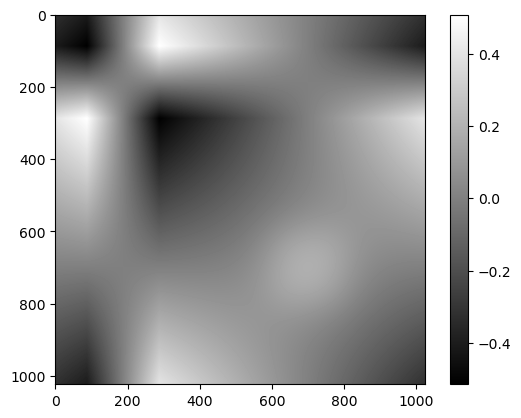

In [61]:
class magnetics(nn.Module):
    def __init__(self, dim, h, dirs, device='cpu'):
        super(magnetics, self).__init__()
        self.dim    = dim   # Mesh size [nx, ny, nz]
        self.h      = h     # cell size [Dx, Dy, Dz]
        self.dirs   = dirs  # magnetic field directions [A, I, A0, I0]
        self.device = device 


    def forward_old(self, M):
        # Solve the forward problem using FFT
        Dz = self.h[2]
        Z  = Dz/2
        dV = torch.prod(self.h)
        Data = 0 
        for i in range(M.shape[-1]):
            I = M[:,:,i]
            P, center, Rf = self.psfLayer(Z)
            
            S = torch.fft.fft2(torch.roll(P, shifts=center, dims=[0,1])).unsqueeze(0).unsqueeze(0)
            B = torch.real(torch.fft.ifft2(S * torch.fft.fft2(I))) 
            Data = Data+B
            Z = Z + Dz
        return Data*dV

    def forward(self, M):
        # Solve the forward problem using FFT
        Dz = self.h[2]
        Z  = Dz/2
        dV = torch.prod(self.h)
        Data = 0 
        for i in range(M.shape[-1]):
            I = M[:,:,i]
            P, center, Rf = self.psfLayer(Z)
            
            S = torch.fft.fftshift(torch.roll(P, shifts=center, dims=[0,1]))
            S = torch.fft.fft2(S)
            S = torch.fft.fftshift(S)

            I_fft = torch.fft.fftshift(I)
            I_fft = torch.fft.fft2(I_fft)
            I_fft = torch.fft.fftshift(I_fft)

            B = torch.fft.fftshift(S * I_fft)
            B = torch.real(torch.fft.ifft2(B))
            Data = Data+B
            Z = Z + Dz
        return Data*dV

    def adjoint(self, I):
        
        Dz = self.h[2]
        dV = torch.prod(self.h)
        Z = Dz/2
        M  = torch.zeros(self.dim[0], self.dim[1], self.dim[2], device=self.device)
        #Mw  = torch.zeros(self.dim[0], self.dim[1], self.dim[2], device=self.device)
        
        for i in range(M.shape[-1]):
            P, center, Rf = self.psfLayer(Z)

            S = torch.fft.fft2(torch.roll(P, shifts=center, dims=[0,1])).unsqueeze(0).unsqueeze(0)
            B = torch.real(torch.fft.fft2(S * torch.fft.ifft2(torch.roll(I, shifts=center, dims=[0,1])))) 
            M[:,:,i] = B

            Z = Z + Dz

        return M*dV

    def depthWeighting(self, I):
        
        Dz = self.h[2]
        dV = torch.prod(self.h)
        Z = Dz/2
        M = torch.zeros_like(I)
        
        for i in range(I.shape[-1]):
            _, center, Rf = self.psfLayer(Z)

            S = torch.fft.fft2(torch.roll(Rf, shifts=center, dims=[0,1])).unsqueeze(0).unsqueeze(0)
            B = torch.real(torch.fft.fft2(S * torch.fft.ifft2(I))) 
            M[:,:,i] = B

            Z = Z + Dz

        return M*dV


    def psfLayer(self, Z):
         #I is the magnetization dip angle 
         # A is the magnetization deflection angle
         # I0 is the geomagnetic dip angle
         # A0 is the geomagnetic deflection angle

        dim2 = torch.div(self.dim,2,rounding_mode='floor')
        Dx = self.h[0]
        Dy = self.h[1]
        I  = self.dirs[0]
        A  = self.dirs[1]
        I0 = self.dirs[2]
        A0 = self.dirs[3]
        
        x = Dx*torch.arange(-dim2[0]+1,dim2[0]+1, device=self.device)
        y = Dy*torch.arange(-dim2[1]+1,dim2[1]+1, device=self.device)
        X,Y = torch.meshgrid(x,y)

        # Get center ready for fftshift.
        center = [1-int(dim2[0]), 1-int(dim2[1])]

        Rf = torch.sqrt(X**2 + Y**2 + Z**2)**5
        PSFx = (2*X**2 - Y**2 - Z**2)/Rf*torch.cos(I)*torch.sin(A) + \
               3*X*Y/Rf**torch.cos(I)*torch.cos(A) + \
               3*X*Z/Rf*torch.sin(I)

        PSFy = 3*X*Y/Rf*torch.cos(I)*torch.sin(A) + \
               (2*Y**2 - X**2 - Z**2)/Rf*torch.cos(I)*torch.cos(A) + \
               3*Y*Z/Rf*torch.sin(I)

        PSFz = 3*X*Z/Rf*torch.cos(I)*torch.sin(A) + \
               3*Z*Y/Rf*torch.cos(I)*torch.cos(A) +\
               (2*Z**2 - X**2 - Y**2)/Rf*torch.sin(I)

        PSF = PSFx*torch.cos(I0)*torch.cos(A0) + \
              PSFy*torch.cos(I0)*torch.sin(A0) + \
              PSFz*torch.sin(I0) 
        
        return PSF, center, Rf

# if False:
# Adjoint test
dim = torch.tensor([1024,1024,512])
h = torch.tensor([100.0, 100.0, 100.0])
dirs = torch.tensor([np.pi/2, np.pi/2, np.pi/2, np.pi/2])
forMod = magnetics(dim, h, dirs)

M = torch.ones(dim[0], dim[1], dim[2], device='cpu') * 0.0
M[600:800, 600:800, 100:400] = 0.1
# M[400:600, 400:600, 100:400] = 0.1

D = forMod(M)
# Q = torch.randn_like(D)
# W = forMod.adjoint(Q)

# print(torch.sum(M*W), torch.sum(D*Q))

# Ma = forMod.adjoint(D) 
plt.imshow(D.view(1024, 1024).cpu().detach().numpy())
plt.colorbar()

print('Done')

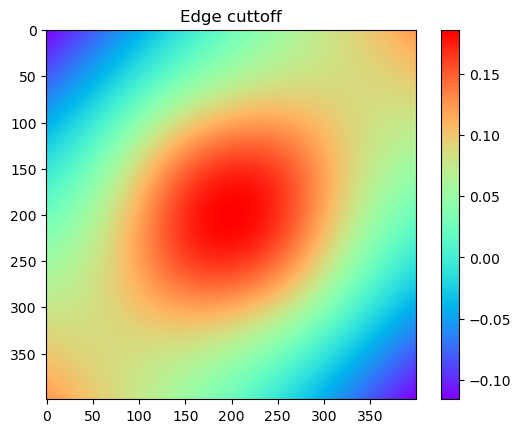

In [64]:
# plt.imshow(D.view(1024, 1024).cpu().detach().numpy()[300:700, 300:700], cmap='rainbow')
plt.imshow(D.view(1024, 1024).cpu().detach().numpy()[500:900, 500:900], cmap='rainbow')
plt.title("Edge cuttoff")
plt.colorbar()

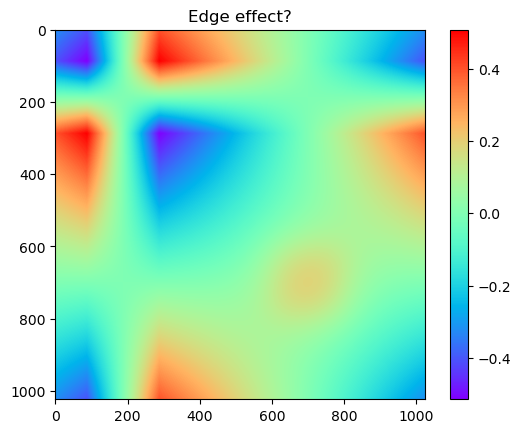

In [62]:
plt.imshow(D.view(1024, 1024).cpu().detach().numpy(), cmap='rainbow')
plt.title("Edge effect?")
plt.colorbar()

In [69]:
x = 100*torch.arange(-512 +1, 512+1, device='cpu')
y = 100*torch.arange(-512 +1, 512+1, device='cpu')
X,Y = torch.meshgrid(x,y)
print(X.shape)

torch.Size([1024, 1024])
